# Lecture 3: Hierarchical Gaussian Models
Scott Linderman <br>
April 1, 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/notebooks/lecture3-hgm.ipynb)



In [1]:
import torch
from torch.distributions import Normal, Gamma, Categorical, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform
torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

In [2]:
class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

## Modeling Test Scores across Schools

Suppose we have test scores from $S$ schools. Let $N_s$ denote the number of students from school $s$ and $x_{s,n} \in \mathbb{R}$ denote the score of the $n$-th student from the $s$-th school. 

We aim to build a probabilistic model of the scores $\mathbf{X} = \{\{x_{s,n}\}_{n=1}^{N_s}\}_{s=1}^S$ that will allow us to study relative performance across schools.
    
The individual scores are not exchangeable since they are organized into groups by school. However, the schools themselves are exchangeable. 
This motivates the following **hierarchical model**:
\begin{align}
    \tau^2 &\sim \chi^{-2}(\nu_0, \tau_0^2) \\
    \mu &\sim \mathcal{N}(\mu_0, \tau^2 / \kappa_0) \\
    \theta_s &\sim \mathcal{N}(\mu, \tau^2) \qquad \text{for } s=1,\ldots,S \\
    x_{s,n} &\sim \mathcal{N}(\theta_s, \sigma_s^2) \qquad \text{for } n=1,\ldots,N_s \text{ and } s=1,\ldots,S
\end{align}

Each school has its own mean $\theta_s$, and the means are conditionally independent given the global mean and variance, $\mu$ and $\tau^2$, respectively. Hence, the means are exchangeable. 

We can simplify the likelihood by observing that as a function of the parameter $\theta_s$,
    \begin{align}
        \prod_{n=1}^{N_s} \mathcal{N}(x_{s,n} \mid \theta_s, \sigma_s^2) 
        % &\propto \exp\left\{-\frac{1}{2\sigma_s^2} (x_{s,n} - \theta_s)^2 \right\} \\
        % &\propto \exp\left\{-\frac{N}{2\sigma_s^2} \theta_s^2 + \frac{N}{\sigma_s^2} \left(\frac{1}{N}\sum_{n=1}^{N_s} x_{s,n}\right) \theta_s \right\} \\
        &\propto \mathcal{N}(\bar{x}_s \mid \theta_s, \bar{\sigma}_s^2)
    \end{align}
where $\bar{x}_s = \tfrac{1}{N_s} \sum_{n=1}^{N_s} x_{s,n}$ and $\bar{\sigma}_s^2 = \tfrac{\sigma_s^2}{N_s}$. 
    
Put differently, the school mean is a **sufficient statistic** of the likelihood (when variance is known).

## Eight Schools Example

We will use data from a classic example given in Ch 5.5 of Gelman et al (2013). This example is used by numerous probabilistic programming libraries, like [TensorFlow Probability](https://www.tensorflow.org/probability/examples/Eight_Schools) and [NumPyro](https://github.com/pyro-ppl/numpyro). 

Gelman et al. say,
> A study was performed for the Educational Testing Service to analyze the effects of special coaching programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.


_Note: This is a little odd, but rather than modeling the scores directly, we will model the treatment effects under a linear model that controls for other stuff. The estimated effects a magnitude and standard error. These will be our $\bar{x}_s$ and. $\bar{\sigma}_s$ values._

_Note: we're given the standard deviations rather than the variances of the scores._



In [3]:
# Hyper parameters
S = 8                # number of schools
mu_0 = 0.0           # prior mean of the global effect
kappa_0 = 0.1        # prior concentration in the NIX prior
nu_0 = 0.1           # degrees of freedom
tausq_0 = 100.0      # prior mean of the variance \tau^2

# This is the data
x_bars = torch.tensor([28, 8, -3, 7, -1, 1, 18, 12])  
sigma_bars = torch.tensor([15, 10, 16, 11, 9, 11, 10, 18])

## Compute the marginal posterior over the global variance

Integrate over $\mu$ to obtain,
\begin{align}
    p(\tau^2 \mid \mathbf{X}, \boldsymbol{\eta}) 
    &\propto \int p(\mu, \tau^2, \mathbf{X} \mid \boldsymbol{\eta}) \, \mathrm{d} \mu \\
    &= p(\tau^2) \int \left[\mathcal{N}(\mu \mid \mu_0, \tau^2/ \kappa_0) \prod_{s=1}^S \mathcal{N}(\bar{x}_s \mid \mu, \bar{\sigma}_s^2 + \tau^2)\right] \, \mathrm{d} \mu 
\end{align}
The integral is very doable (a good exercise!) but it's a bit of a pain.

Alternatively, note that the following holds for any $\mu$:
\begin{align}
    p(\tau^2 \mid \mathbf{X}, \boldsymbol{\eta}) 
    &= \frac{p(\mu, \tau^2 \mid \mathbf{X}, \boldsymbol{\eta})}{p(\mu \mid \tau^2, \mathbf{X}, \boldsymbol{\eta})} 
    \propto \frac{p(\tau^2) \mathcal{N}(\mu \mid \mu_0, \tau^2/ \kappa_0) \prod_{s=1}^S \mathcal{N}(\bar{x}_s \mid \mu, \bar{\sigma}_s^2 + \tau^2)}{\mathcal{N}(\mu \mid \hat{\mu}, v_\mu)}.
\end{align}
This is just Bayes' rule.
    
Plug in $\mu = \hat{\mu}$ since that will cause many terms in the denominator to disappear. Then,
\begin{align}
    p(\tau^2 \mid \mathbf{X}, \boldsymbol{\eta}) &\propto p(\tau^2) \frac{\sqrt{v_\mu} }{\tau} e^{-\frac{\kappa_0}{2 \tau^2} (\mu - \mu_0)^2}
    \prod_{s=1}^S \frac{1}{\sqrt{\bar{\sigma}_s^2 + \tau^2}} \exp\left\{-\frac{1}{2} \left(\frac{\bar{x}_s - \hat{\mu}}{\sqrt{\bar{\sigma}_s^2 + \tau^2}} \right)^2 \right\} \triangleq f(\tau^2)
\end{align}
where
\begin{align}
    v_\mu &= \frac{1}{\lambda_0 +\sum_{s=1}^S \lambda_s} &
    \hat{\mu} &= \frac{\lambda_0 \mu_0 + \sum_{s=1}^S \lambda_s \bar{x}_s}{\lambda_0 + \sum_{s=1}^S \lambda_s } &
    \lambda_0 &= \frac{\kappa_0}{\tau^2} &
    \lambda_s &= \frac{1}{\bar{\sigma}_s^2 + \tau^2}
\end{align}

This function is complicated because both $v_\mu$ and $\hat{\mu}$ depend on $\tau^2$. Nevertheless, $\tau^2$ is only a one-dimensional variable, so we can use numerical quadrature to compute the normalizing constant $\int f(\tau^2) \, \mathrm{d} \tau^2$ and draw samples from this posterior. 

In [4]:
def compute_log_f(tausq, x_bars, sigma_bars, mu_0, kappa_0, nu_0, tausq_0):
    """
    Compute \log f(\tau^2), as defined above.

    Args:

    tausq:      a length (T,) tensor of \tau^2 values 
    x_bars:     a length (S,) tensor of \bar{x}_s values
    sigma_bars: a length (S,) tensor of \bar{\sigma}_s values
    mu_0:       prior mean of \mu
    kappa_0:    prior precision of \mu
    nu_0:       degrees of freedom of prior on \tau^2
    tausq_0:    mean of prior on \tau^2

    Returns:

    \log f(\tau^2) evaluated at each of the (T,) values of tausq
    """
    log_f = ScaledInvChiSq(nu_0, tausq_0).log_prob(tausq)

    # Compute the parameters of the posterior on the global mean, \mu
    # Handle broadcasting over a 1D tensor of \tausq values.
    lambda_0 = kappa_0 / tausq
    lambda_s = 1 / (sigma_bars[None, :]**2 + tausq[:, None])
    v_mu = 1 / (lambda_0 + lambda_s.sum(axis=-1))
    mu_hat = (lambda_0 * mu_0 + (lambda_s * x_bars[None, :]).sum(axis=-1)) / \
        (lambda_0 + lambda_s.sum(axis=-1))

    # Back to log_f
    log_f += 0.5 * torch.log(v_mu) - 0.5 * torch.log(tausq)
    log_f += -0.5 * kappa_0 / tausq * (mu_hat - mu_0)**2
    log_f += 0.5 * torch.log(lambda_s).sum(axis=-1)
    log_f += -0.5 * (lambda_s * (x_bars[None, :] - mu_hat[:, None])**2).sum(axis=-1)

    return log_f

Now evaluate $\log f(\tau^2)$ on a dense grid of $\tau^2$ values. Then use the [**log-sum-exp trick**](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations) to normalize the values in the log space before exponentiating to get the posterior density. 

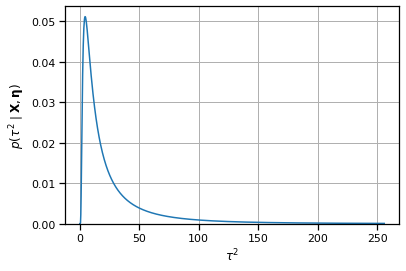

In [5]:
tausq_grid = torch.linspace(1e-1, 256, 1000)
log_f = compute_log_f(tausq_grid, x_bars, sigma_bars, 
                      mu_0, kappa_0, nu_0, tausq_0)

# normalize and exponentiate to get the posterior probability
dt = tausq_grid[1] - tausq_grid[0]
p_tausq = torch.exp(log_f - torch.logsumexp(log_f, 0) - torch.log(dt))

# Plot the pdf
plt.plot(tausq_grid, p_tausq)
plt.ylim(0, plt.ylim()[1])
plt.xlabel(r"$\tau^2$")
# plt.xticks(torch.arange(0,401, 50))
plt.ylabel(r"$p(\tau^2 \mid \mathbf{X}, \mathbf{\eta})$")
plt.grid(True)

The posterior probability of $\tau^2$ is a little harder to see than the posterior distribution on $\tau$. Apply the change of variables to look at $p(\tau \mid \mathbf{X}, \boldsymbol{\eta})$.

posterior mean of tau:
E[tau]: 4.459  Std[tau]: 2.541


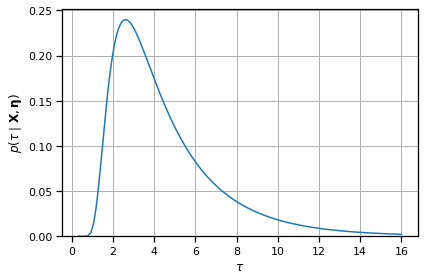

In [6]:
tau_grid = torch.sqrt(tausq_grid)
p_tau = 2 * p_tausq * tau_grid

print("posterior mean of tau:")
tau_mean = torch.sum(p_tau[:-1] * torch.diff(tau_grid) * tau_grid[:-1])
tau_var = torch.sum(p_tau[:-1] * torch.diff(tau_grid) * (tau_grid[:-1] - tau_mean)**2)
print("E[tau]: {:.3f}  Std[tau]: {:.3f}".format(tau_mean, torch.sqrt(tau_var)))

plt.plot(tau_grid, p_tau)
plt.ylim(0, plt.ylim()[1])
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau \mid \mathbf{X}, \mathbf{\eta})$")
plt.grid(True)

plt.tight_layout()
plt.savefig("p_tau.pdf")

## Compute the posterior of the global mean given the global variance

To compute the posterior over the global mean $\mu$ given the global variance $\tau$, we need to marginalize over the per-school parameters $\boldsymbol{\theta}$. This is usually intractable, but since this model is conditionally linear and Gaussian, we can do it analytically.
\begin{align}
    p(\mu \mid \tau^2, \mathbf{X}, \boldsymbol{\eta}) 
    % &\propto p(\mu, \tau^2, \mathbf{X}, \boldsymbol{\eta}) \\
    &\propto \int p(\mu, \tau^2, \boldsymbol{\theta}, \mathbf{X} \mid \boldsymbol{\eta}) \, \mathrm{d} \boldsymbol{\theta} \\
    &\propto \prod_{s=1}^S \int \mathcal{N}(\theta_s \mid \mu, \tau^2) \, \mathcal{N}(\bar{x}_s \mid \theta_s, \bar{\sigma}_s^2) \, \mathrm{d} \theta_s \\
    &= \prod_{s=1}^S \mathcal{N}(\bar{x}_s \mid \mu, \bar{\sigma}_s^2 + \tau^2) \\
    &\propto \mathcal{N}(\mu \mid \hat{\mu}, v_\mu) 
\end{align}
\vspace{-2em}
where
\begin{align}
    v_\mu &= \frac{1}{\lambda_0 + \sum_{s=1}^S \lambda_s} &
    \hat{\mu} &= \frac{\lambda_0 \mu_0 + \sum_{s=1}^S \lambda_s \bar{x}_s}{\lambda_0 + \sum_{s=1}^S \lambda_s } &
    \lambda_0 &= \kappa_0 / \tau^2 &
    \lambda_s &= \frac{1}{\bar{\sigma}_s^2 + \tau^2}
\end{align}
The posterior mean of $\mu$ is a precision-weighted average of the school means.


In [7]:
def compute_posterior_mu(tausq, mu_0, kappa_0, x_bars, sigma_bars):
    """
    Compute the mean and variance of the posterior distribution on the global 
    mean given the global variance, as defined above.

    Args:

    tausq:      a length (T,) tensor of \tau^2 values 
    mu_0:       prior mean of \mu
    kappa_0:    prior precision of \mu
    x_bars:     a length (S,) tensor of \bar{x}_s values
    sigma_bars: a length (S,) tensor of \bar{\sigma}_s values

    Returns:

    \hat{\mu} and v_\mu evaluated at each of the (T,) values of tausq
    """
    lambda_0 = kappa_0 / tausq
    lambda_s = 1 / (sigma_bars[None, :]**2 + tausq[:, None])
    v_mu = 1 / (lambda_0 + lambda_s.sum(axis=-1))
    mu_hat = (lambda_0 * mu_0 + (lambda_s * x_bars[None, :]).sum(axis=-1)) / \
        (lambda_0 + lambda_s.sum(axis=-1))
    return mu_hat, v_mu

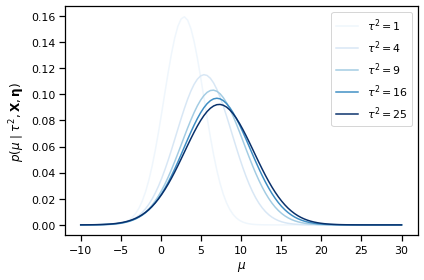

In [8]:
# Pick a few values of \tau^2 and plot the posterior on mu for each value
tausqs = torch.tensor([1, 4, 9, 16, 25])
mu_hat, v_mu = compute_posterior_mu(tausqs, mu_0, kappa_0, x_bars, sigma_bars)

mu_grid = torch.linspace(-10, 30, 100)
for tausq, mean, var in zip(tausqs, mu_hat, v_mu):
    plt.plot(mu_grid, 
             torch.exp(Normal(mean, torch.sqrt(var)).log_prob(mu_grid)),
             color=Blues((tausq / tausqs.max()).numpy()),
             label=r"$\tau^2 = {:.0f}$".format(tausq)
             )
plt.xlabel("$\mu$")
plt.ylabel(r"$p(\mu \mid \tau^2, \mathbf{X}, \mathbf{\eta})$")
plt.legend()

plt.tight_layout()
plt.savefig("p_mu.pdf")

## Compute the posterior of the per-school effect

This is the easy one:
    \begin{align}
        p(\boldsymbol{\theta} \mid \mu, \tau^2, \mathbf{X}, \boldsymbol{\eta})
        &\propto \prod_{s=1}^S \Big[ \mathcal{N}(\theta_s \mid \mu, \tau^2) \mathcal{N}(\bar{x}_s \mid \theta_s, \bar{\sigma}_s^2) \Big] \\
        &\propto \prod_{s=1}^S \mathcal{N}(\theta_s \mid \hat{\theta}_s, v_s)
    \end{align}
    where
    \begin{align}
        v_s &= \left(\frac{1}{\bar{\sigma}_s^2} + \frac{1}{\tau^2} \right)^{-1} &
        \hat{\theta}_s &= v_s \left(\frac{\bar{x}_s}{\bar{\sigma}_s^2} + \frac{\mu}{\tau^2} \right)
    \end{align}
    I.e. the conditional means are precision-weighted averages of the prior and sample means.

In [9]:
def compute_posterior_theta(tausq, mu, x_bars, sigma_bars):
    """
    Compute the mean and variance of the posterior distribution on per-school
    means and variances given the global variance, \tau^2, and the global mean,
    \mu. 

    Note: Broadcast over a tensor of tausq and mu values. 

    Args:

    tausq:      a length (T,) tensor of \tau^2 values 
    mu:         a length (T,) tensor of mu values 
    x_bars:     a length (S,) tensor of \bar{x}_s values
    sigma_bars: a length (S,) tensor of \bar{\sigma}_s values

    Returns:

    (T, S) arrays of \hat{\theta}_s and v_{\theta_s} evaluated at each of the 
    T values of tausq and mu for each of the S schools.
    """
    v_theta = 1 / ((1 / sigma_bars[None, :]**2) + (1 / tausq[:, None]))

    theta_hat = v_theta * ((x_bars[None, :] / sigma_bars[None, :]**2) \
                           + mu_hat[:, None] / tausq[:, None])
                           
    return theta_hat, v_theta

## Compute the posterior distribution of the per-school effect given the global variance

Last but not least, note that,
\begin{align}
    p(\theta_s \mid \tau, \mathbf{x}, \boldsymbol{\eta}) &= 
    \int p(\theta_s \mid \mu, \tau, \mathbf{x}, \boldsymbol{\eta}) \, p(\mu \mid \tau, \mathbf{x}, \boldsymbol{\eta}) \, \mathrm{d} \mu \\
    &\propto \int \mathcal{N}(\bar{x}_s \mid \theta_s, \bar{\sigma}_s^2) \, \mathcal{N}(\theta_s \mid \mu, \tau^2) \, \mathcal{N}(\mu \mid \hat{\mu}, v_\mu) \, \mathrm{d} \mu \\
    &\propto \mathcal{N}(\bar{x}_s \mid \theta_s, \bar{\sigma}_s^2) \, \mathcal{N}(\theta_s \mid \hat{\mu}, \tau^2 + v_\mu) \\
    &= \mathcal{N}(\theta_s \mid \hat{\theta}_s, v_{\theta_s}) 
\end{align}
where
\begin{align}
    v_{\theta_s} &= \left(\frac{1}{\bar{\sigma}_2^2} + \frac{1}{\tau^2 + v_\mu^2} \right)^{-1} 
    &
    \hat{\theta}_s &= v_{\theta_s} \left(\frac{\bar{x}_s}{\bar{\sigma}_s^2} + \frac{\hat{\mu}}{\tau^2 + v_\mu} \right)
\end{align}
Again, note that $\tau^2$ affects all of these quantities!

In [10]:
def compute_posterior_theta2(tausq, mu_0, kappa_0, x_bars, sigma_bars):
    """
    Compute the mean and variance of the posterior distribution on the 
    per-school means given the global variance, as defined above.

    Note: the `[None, :]` syntax is creating new axes so that the elementwise
    operations broadcast as desired. The result should be a pair of (T, S) 
    arrays where T is the number of tausq values and S is the number of schools.

    Args:

    tausq:      a length (T,) tensor of \tau^2 values 
    mu_0:       prior mean of \mu
    kappa_0:    prior precision of \mu
    x_bars:     a length (S,) tensor of \bar{x}_s values
    sigma_bars: a length (S,) tensor of \bar{\sigma}_s values

    Returns:

    (T, S) arrays of \hat{\theta}_s and v_{\theta_s} evaluated at each of the 
    T values of tausq for each of the S schools.
    """
    lambda_0 = kappa_0 / tausq
    lambda_s = 1 / (sigma_bars[None, :]**2 + tausq[:, None])
    v_mu = 1 / (lambda_0 + lambda_s.sum(axis=-1))
    mu_hat = (lambda_0 * mu_0 + (lambda_s * x_bars[None, :]).sum(axis=-1)) / \
        (lambda_0 + lambda_s.sum(axis=-1))
    
    v_theta = 1 / ((1 / sigma_bars[None, :]**2) \
                   + (1 / (tausq[:, None] + v_mu[:, None])))
    theta_hat = v_theta * ((x_bars[None, :] / sigma_bars[None, :]**2) \
                           + mu_hat[:, None] / (tausq[:, None] + v_mu[:, None]))
                           
    return theta_hat, v_theta

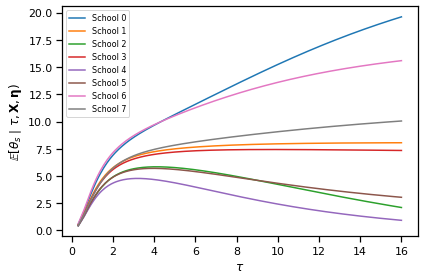

In [11]:
theta_hat, v_theta = compute_posterior_theta2(
    tausq_grid, mu_0, kappa_0, x_bars, sigma_bars)

# Plot the posterior mean as a function of \tau for all schools at once
for s in range(S):
    plt.plot(tau_grid, theta_hat[:, s], label="School {}".format(s))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathbb{E}[\theta_s \mid \tau, \mathbf{X}, \mathbf{\eta})$")
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig("p_theta.pdf")

Now plot the posterior over $\theta_s$ over a range of $\tau$'s separately for each school. 

In [12]:
# fig, axs = plt.subplots(S, 1, figsize=(3, 3*S), sharex=True)
# for s in range(S):
#     ln = axs[s].plot(tau_grid, theta_hat[:, s])
#     axs[s].fill_between(tau_grid, 
#                         theta_hat[:, s] - 2 * torch.sqrt(v_theta[:, s]),
#                         theta_hat[:, s] + 2 * torch.sqrt(v_theta[:, s]),
#                         color=ln[0].get_color(), alpha=0.1
#                         )

#     if s == S-1: axs[s].set_xlabel(r"$\tau$")
#     axs[s].set_ylabel(r"$p(\theta_s \mid \tau, X, \eta)$")
#     axs[s].set_title("School {}".format(s+1))

# plt.tight_layout()

## Draw samples from the posterior distribution


In [13]:
N_samples = 10000

# Sample global standard deviation, \tau
centers = 0.5 * (tau_grid[:-1] + tau_grid[1:])
width = torch.diff(tau_grid)
inds = Categorical(probs=p_tau[:-1] * width).sample((N_samples,))
tau_samples = centers[inds]

# Sample global mean, \mu
mu_hat, v_mu = compute_posterior_mu(
    tau_samples**2, mu_0, kappa_0, x_bars, sigma_bars)
mu_samples = Normal(mu_hat, torch.sqrt(v_mu)).sample()

# Sample per-school effects, \theta_s
theta_hat, v_theta = compute_posterior_theta(tau_samples**2, mu_samples,
                                             x_bars, sigma_bars)
theta_samples = Normal(theta_hat, torch.sqrt(v_theta)).sample()

# plt.hist(tau_samples, 50, density=True)
# plt.plot(tau_grid, p_tau)

In [14]:
print("posterior statistics of school effect (theta_s)")
print("mean:   ", torch.mean(theta_samples, axis=0))
print("std:    ", torch.std(theta_samples, axis=0))
print("median: ", torch.median(theta_samples, axis=0).values)
print("5%:     ", torch.quantile(theta_samples, 0.05, axis=0))
print("95%:    ", torch.quantile(theta_samples, 0.95, axis=0))

posterior statistics of school effect (theta_s)
mean:    tensor([8.6455, 6.8015, 5.7383, 6.7419, 5.0388, 5.7982, 8.5835, 6.9828])
std:     tensor([5.3350, 4.2647, 4.6378, 4.3968, 4.1119, 4.3157, 4.7577, 4.8330])
median:  tensor([7.7211, 6.5044, 5.7342, 6.4147, 5.2019, 5.6808, 7.8380, 6.5527])
5%:      tensor([ 2.0518,  0.4878, -1.8416,  0.1996, -2.0148, -1.0938,  2.3629, -0.0491])
95%:     tensor([18.6214, 14.1064, 13.1661, 14.5029, 11.3792, 12.8829, 17.5121, 15.2860])


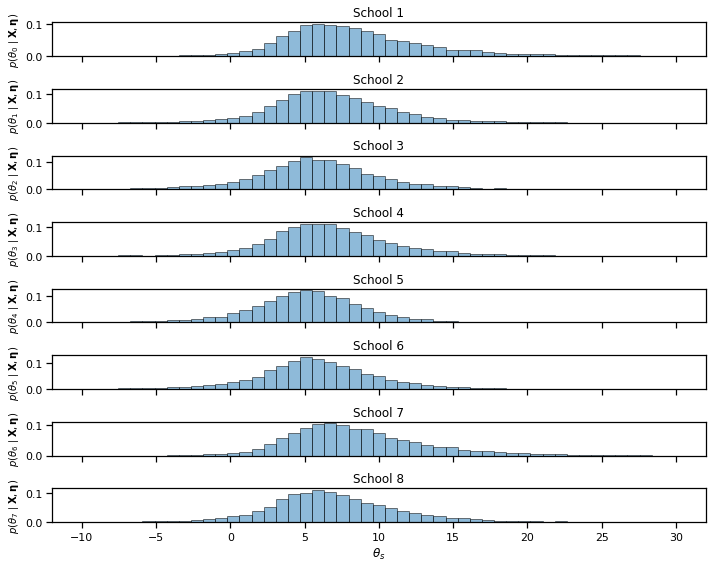

In [15]:
bins = torch.linspace(-10, 30, 50)
fig, axs = plt.subplots(S, 1, figsize=(10, 8), sharex=True)
for s in range(S):
    axs[s].hist(theta_samples[:, s], bins, edgecolor='k', alpha=0.5, density=True)
    
    if s == S-1: axs[s].set_xlabel(r"$\theta_s$")
    axs[s].set_ylabel(r"$p(\theta_" + str(s) + r" \mid \mathbf{X}, \mathbf{\eta})$",
                      fontsize=10)
    axs[s].set_title("School {}".format(s+1))

plt.tight_layout()
plt.savefig("theta_samples.pdf")

## Recap

The hierarchical Gaussian model is about the most complicated model for which we can still perform "exact" inference. Even here though, we had to use numerical integration to compute the posterior over the global variance, $\tau^2$. We could do so because it's only a 1D variable. 

### Questions
- How sensitive is the posterior to the choice of prior $p(\mu, \tau^2)$? How would you measure this sensitivity?
- How could you determine "reasonable" values for this prior?

